## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

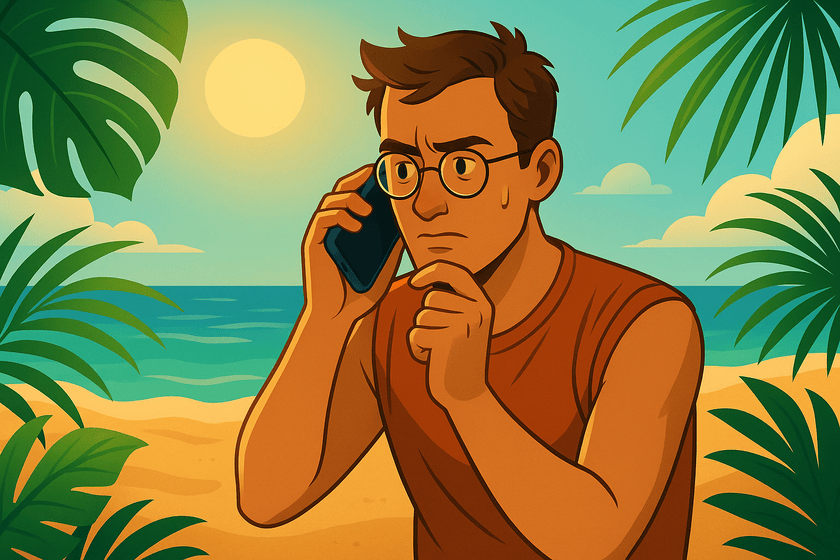

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

# 0. Wprowadzenie

Powiązanie z zadaniem 2, importy bibliotek, załadowanie zbioru

# 0.0 Co będziemy robić

W tym zadaniu stworzymy 2 sieci - pierwszą MLP - będzie to nasza prosta sieć Baseline. Drugą będzie CNN - na niej wykonamy właściwy eksperyment.
Czym się różnią te dwie sieci?
* MLP przyjmuje jako wejście spłaszczone dane wejściowe, w naszym ćwiczeniu obraz będziemy przekształcać obraz 28 x 28 pikseli na wektor 784. Jest to sieć prosta do implementacji, działą dobrze na małych zbiorach.
* CNN radzi sobie z przestrzennymi obrazami np. 2D lub 3D, jest bardziej skomplikowana i wymaga więcej zasobów.

## 0.1 Co z poprzednich ćwiczeń może się przydać w tym.

Oto czego się nauczyłam z poprzednich ćwiczeń i na pewno warto wziąć pod uwagę w tym:
* Dane trzeba podzielić na testowe i treningowe. Dobrze jest dzielić dane także na walidacyjne, które przydałyby się do monitorowania podczas treningu.
* Warto wykonywać normalizację danych
* Nie można dopuścić do wycieku danych

## 0.2 Ustawienia i importy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import time
import os
import random
from torch.utils.data import Subset
from torch.optim import Adam

Dla odtwarzalnego losowania ustawiamy jednakowy SEED:

In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

*he he 42*

Automatyczny wybór środowiska, aby poprawić przenośność kodu:

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 0.3 Ładowanie zbioru

In [5]:
# transformacje: tensory + normalizacja (średnia/odchylenie MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# pobranie danych (zapisze do folderu ./data)
data_root = "./data"
train_full = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_ds    = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

# podział danych na train/val
val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128 # z tą wieklkością działa, więc nie zmniejszam
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)

(55000, 5000, 10000)

## 0.4 Wizualizacja danych

Wizualizacja przykładowych pierwszych ośmiu obrazów i etykiet:

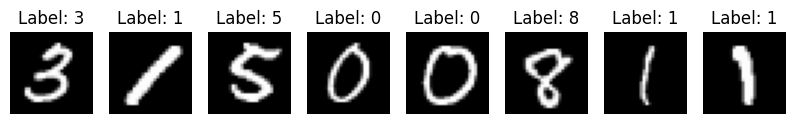

In [6]:
images, labels = next(iter(train_loader))
images = images[:8]
labels = labels[:8]

fig, axes = plt.subplots(1, len(images), figsize=(10, 6))
for ax, img, lab in zip(axes, images, labels):
    ax.imshow(img.squeeze().numpy(), cmap="gray")
    ax.set_title(f"Label: {lab.item()}")
    ax.axis("off")
plt.show()

Wstęp został po prostu przepisany ze ściągi i nic odkrywczego tutaj nie napisałam, więc przejdźmy do właściwego zadania.

# 1. Baseline - tworzenie zwykłej sieci neuronowej

Aby osadzić dalsze eksperymenty w kontekście porównania do zwykłej, prostej sieci neuronowej, zacznijmy od analizy jej.

Nie będziemy używać wszystkich danych, żeby nie trwało to długo, weźmiemy tylko połowę wszystkich załadowanych danych.

In [7]:
train_baseline = Subset(train_ds, list(range(27500)))
val_baseline = Subset(val_ds, list(range(2500)))
test_baseline = Subset(test_ds, list(range(5000)))

train_loader_baseline = DataLoader(train_baseline, batch_size=BATCH_SIZE, shuffle=True)
val_loader_baseline = DataLoader(val_baseline, batch_size=BATCH_SIZE, shuffle=False)
test_loader_baseline = DataLoader(test_baseline, batch_size=BATCH_SIZE, shuffle=False)

Teraz definiujemy najprostszą możliwą sieć – zwykłą sieć neuronową MLP. Musimy spłaszczyć obraz 78x78 pikseli do wektora 784. W tym celu lekko zmodyfikowałam sieć ze ściągi:

In [8]:
# 1. Definicja prostej sieci MLP
class Baseline(nn.Module):
    # 2. Warstwy i funkcje aktywacji
    def __init__(self, input_size, hidden_size, output_size):
        super(Baseline, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Pierwsza warstwa liniowa
        self.relu = nn.ReLU()                          # Funkcja aktywacji ReLU
        self.fc2 = nn.Linear(hidden_size, output_size) # Druga warstwa liniowa

    # 3. Przepływ danych
    def forward(self, x):
        x = self.fc1(x)    # Pierwsza warstwa liniowa
        x = self.relu(x)   # Funkcja aktywacji ReLU
        x = self.fc2(x)    # Druga warstwa liniowa
        return x

# 4. Instancja zdefiniowanej klasy sieci neuronowej
input_dim = 784      # 28*28
hidden_dim = 128
output_dim = 10
modelBaseline = Baseline(input_dim, hidden_dim, output_dim).to(device)


Mamy tutaj 1 warstę ukrytą z 128 neuronami i wyjście `output_dim` z 10 neuronami, bo do zidentyfikowania jest 10 różnych cyfr.

Teraz wykonajmy trening naszej prostej sieci:

In [9]:
# Funkcja straty i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelBaseline.parameters(), lr=0.001) # Wybieramy Adama

In [10]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Spłaszczenie obrazów (batch_size, 1, 28, 28) -> (batch_size, 784)
        inputs = inputs.view(inputs.size(0), -1)

        optimizer.zero_grad()
        # 1. Forward pass
        outputs = model(inputs)
        # 2. Loss calculation:
        loss = criterion(outputs, labels)
        # 3. Backward pass
        loss.backward()
        # 4. Optimizer step
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

I ewaluacja na zbiorze testowym:

In [11]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

Uruchomienie treningu (ograniczymy tylko do 5 epok):

In [12]:
num_epochs = 5

for epoch in range(num_epochs):
    # trening
    train_loss, train_acc = train_one_epoch(modelBaseline, train_loader_baseline, optimizer, criterion, device)
    # testowanie
    test_loss, test_acc = evaluate(modelBaseline, test_loader_baseline, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs} | Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

Epoch 1/3 | Train loss: 0.4045, Train acc: 0.8835 | Test loss: 0.2973, Test acc: 0.9154
Epoch 2/3 | Train loss: 0.1877, Train acc: 0.9467 | Test loss: 0.2209, Test acc: 0.9338
Epoch 3/3 | Train loss: 0.1353, Train acc: 0.9621 | Test loss: 0.1847, Test acc: 0.9440


Jak widać, sieć uzyskuje wyniki niezbyt zadowalające, ale jest to spowodowane tym, że ćwiczona jest na małej ilości danych i tylko przez 5 epok. Jest to też normalne dla tego typu sieci.

# 2. Konwolucyjna sieć neuronowa (CNN)

Zacznijmy od zdefiniowania takiej sieci neuronowej

In [13]:
class CNN(nn.Module):
    def __init__(self, num_classes=10, conv1_out=32, conv2_out=64, dropout = 0.25):
        super().__init__()

        self.conv1 = nn.Conv2d(1, conv1_out, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.Linear(conv2_out * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = CNN(conv1_out=32, conv2_out=64, dropout = 0.25).to(device)

Używamy ReLU żeby wprowadzić nieliniowość

# 3. Metryki

## 3.0 Accuracy

Jest to naturalna metryka dla zbalansowanych danych.


Tak samo jak przy baseline, zmierzymy jak dobrze radzi sobie sieć, ale tym razem użyjemy wszystkich danych.

In [14]:
EPOCHS = 10
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

Ep 01/10 | train loss 0.2198 acc 0.9320 | val loss 0.0594 acc 0.9832
Ep 02/10 | train loss 0.0675 acc 0.9792 | val loss 0.0403 acc 0.9876
Ep 03/10 | train loss 0.0508 acc 0.9843 | val loss 0.0362 acc 0.9884
Ep 04/10 | train loss 0.0416 acc 0.9864 | val loss 0.0406 acc 0.9880
Ep 05/10 | train loss 0.0358 acc 0.9887 | val loss 0.0347 acc 0.9900
Ep 06/10 | train loss 0.0314 acc 0.9903 | val loss 0.0423 acc 0.9872
Ep 07/10 | train loss 0.0271 acc 0.9912 | val loss 0.0264 acc 0.9916
Ep 08/10 | train loss 0.0254 acc 0.9914 | val loss 0.0322 acc 0.9910
Ep 09/10 | train loss 0.0214 acc 0.9929 | val loss 0.0323 acc 0.9912
Ep 10/10 | train loss 0.0212 acc 0.9929 | val loss 0.0266 acc 0.9924
Czas treningu: 138.8s


In [ ]:
def stats():
  history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
  start = time.time()
  for epoch in range(1, EPOCHS+1):
      tr_loss, tr_acc = run_epoch(train_loader, train=True)
      va_loss, va_acc = run_epoch(val_loader, train=False)
      history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
      history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
      print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
  print(f"Czas treningu: {time.time()-start:.1f}s")

stats()

Od razu widzimy, że wyniki CNN są zdecydowanie lepsze od MLP.

## 3.1 Confusion Matrix

Moje ulubione narzędzie, bo pozwala łatwo zrozumieć, jakie błędy robi model i dlaczego (np. podobieństwo cyfr). Zdefiniujmy funkcję, której na pewno wiele razy jeszcze użyjemy w tym zadaniu

In [15]:
def matrix():
  model.eval()
  all_preds, all_targets = [], []
  with torch.no_grad():
      for xb, yb in test_loader:
          xb = xb.to(device, non_blocking=True)
          logits = model(xb)
          preds = logits.argmax(1).cpu().numpy()
          all_preds.append(preds)
          all_targets.append(yb.numpy())

  y_pred = np.concatenate(all_preds)
  y_true = np.concatenate(all_targets)

  test_acc = (y_pred == y_true).mean()
  print(f"Test accuracy: {test_acc:.4f}")


  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(6,6))
  plt.imshow(cm, interpolation='nearest')
  plt.title("Confusion Matrix (MNIST)")
  plt.colorbar()
  tick_marks = np.arange(10)
  plt.xticks(tick_marks, tick_marks)
  plt.yticks(tick_marks, tick_marks)

  thresh = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('Prawdziwa klasa')
  plt.xlabel('Predykcja')
  plt.tight_layout()
  plt.show()

  print(classification_report(y_true, y_pred, digits=4))

Test accuracy: 0.9923


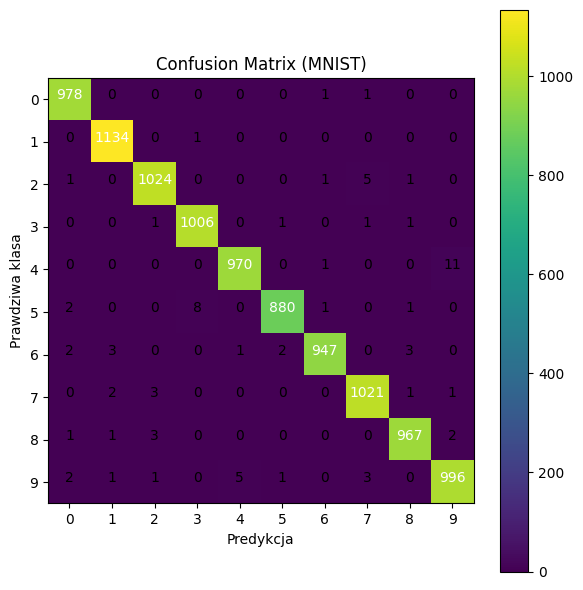

              precision    recall  f1-score   support

           0     0.9919    0.9980    0.9949       980
           1     0.9939    0.9991    0.9965      1135
           2     0.9922    0.9922    0.9922      1032
           3     0.9911    0.9960    0.9936      1010
           4     0.9939    0.9878    0.9908       982
           5     0.9955    0.9865    0.9910       892
           6     0.9958    0.9885    0.9921       958
           7     0.9903    0.9932    0.9917      1028
           8     0.9928    0.9928    0.9928       974
           9     0.9861    0.9871    0.9866      1009

    accuracy                         0.9923     10000
   macro avg     0.9924    0.9921    0.9922     10000
weighted avg     0.9923    0.9923    0.9923     10000



In [16]:
matrix()

# 4. Struktura sieci

Wykonajmy testy zmieniając szerokość i głębokość sieci. Zacznijmy od zmniejszenia liczby filtrów.

In [17]:
model = CNN(conv1_out=16, conv2_out=32, dropout = 0.25).to(device)

optimizer = Adam(model.parameters(), lr=lr)

stats()

Ep 01/10 | train loss 0.2813 acc 0.9132 | val loss 0.0794 acc 0.9766
Ep 02/10 | train loss 0.0883 acc 0.9727 | val loss 0.0534 acc 0.9844
Ep 03/10 | train loss 0.0671 acc 0.9795 | val loss 0.0478 acc 0.9850
Ep 04/10 | train loss 0.0542 acc 0.9835 | val loss 0.0392 acc 0.9882
Ep 05/10 | train loss 0.0458 acc 0.9855 | val loss 0.0383 acc 0.9888
Ep 06/10 | train loss 0.0417 acc 0.9861 | val loss 0.0363 acc 0.9866
Ep 07/10 | train loss 0.0374 acc 0.9884 | val loss 0.0346 acc 0.9898
Ep 08/10 | train loss 0.0336 acc 0.9893 | val loss 0.0364 acc 0.9884
Ep 09/10 | train loss 0.0303 acc 0.9902 | val loss 0.0335 acc 0.9904
Ep 10/10 | train loss 0.0287 acc 0.9908 | val loss 0.0355 acc 0.9908
Czas treningu: 124.9s


Zmniejszenie liczby filtrów pogorszyło dokładność, co pokazuje że zbyt mała pojemność sieci ogranicza jej możliwości rozpoznawania wzorców. W zamian, czas treningu spadł. Teraz podwyższmy liczbę filtrów czterokrotnie.

In [18]:
model = CNN(conv1_out=64, conv2_out=128, dropout = 0.25).to(device)

optimizer = Adam(model.parameters(), lr=lr)

stats()

Ep 01/10 | train loss 0.1783 acc 0.9451 | val loss 0.0542 acc 0.9824
Ep 02/10 | train loss 0.0610 acc 0.9814 | val loss 0.0423 acc 0.9858
Ep 03/10 | train loss 0.0453 acc 0.9859 | val loss 0.0349 acc 0.9890
Ep 04/10 | train loss 0.0347 acc 0.9891 | val loss 0.0382 acc 0.9884
Ep 05/10 | train loss 0.0297 acc 0.9906 | val loss 0.0293 acc 0.9912
Ep 06/10 | train loss 0.0271 acc 0.9906 | val loss 0.0294 acc 0.9908
Ep 07/10 | train loss 0.0212 acc 0.9929 | val loss 0.0335 acc 0.9902
Ep 08/10 | train loss 0.0199 acc 0.9935 | val loss 0.0335 acc 0.9914
Ep 09/10 | train loss 0.0179 acc 0.9942 | val loss 0.0284 acc 0.9918
Ep 10/10 | train loss 0.0165 acc 0.9946 | val loss 0.0297 acc 0.9916
Czas treningu: 140.4s


Zwiększenie liczby filtrów nie poprawiło wyników – wręcz przeciwnie, dokładność spadła minimalnie. Załóżmy, że chcemy jak najlepszy model, więc zostawiamy początkową liczbę filtrów. Następnym naszym badaniem będzie sprawdzenie jak na wynik wpłynie dodanie kolejnej - trzeciej warstwy konwolucyjnej.

In [21]:
class CNN2(nn.Module):
    def __init__(self, num_classes=10, dropout = 0.25):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [22]:
model = CNN2(dropout = 0.25).to(device)

optimizer = Adam(model.parameters(), lr=lr)

stats()

Ep 01/10 | train loss 0.2444 acc 0.9227 | val loss 0.0598 acc 0.9820
Ep 02/10 | train loss 0.0630 acc 0.9809 | val loss 0.0616 acc 0.9778
Ep 03/10 | train loss 0.0479 acc 0.9851 | val loss 0.0351 acc 0.9902
Ep 04/10 | train loss 0.0389 acc 0.9879 | val loss 0.0399 acc 0.9898
Ep 05/10 | train loss 0.0331 acc 0.9901 | val loss 0.0280 acc 0.9916
Ep 06/10 | train loss 0.0292 acc 0.9909 | val loss 0.0260 acc 0.9926
Ep 07/10 | train loss 0.0253 acc 0.9921 | val loss 0.0241 acc 0.9926
Ep 08/10 | train loss 0.0221 acc 0.9931 | val loss 0.0357 acc 0.9896
Ep 09/10 | train loss 0.0208 acc 0.9933 | val loss 0.0291 acc 0.9918
Ep 10/10 | train loss 0.0174 acc 0.9942 | val loss 0.0272 acc 0.9916
Czas treningu: 126.1s


Co ciekawe, wyniki się nie poprawiły. W związku z tym wrócimy do wykonywania dalszych eksperymentów na sieci z 2 warstwami konwolucyjnymi.

# 5. Dropout

Nasza sieć CNN miała też w parametrach możliwość doboru dropoutu. Początkowo ustawiłam go na 0.25, ale sprawdźmy czy inne możliwości dają lepsze rezultaty.

In [28]:
for i in [0.1, 0.35, 0.5]:
    model = CNN(conv1_out=32, conv2_out=64, dropout = i).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    stats()

Ep 01/10 | train loss 0.1942 acc 0.9415 | val loss 0.0605 acc 0.9826
Ep 02/10 | train loss 0.0563 acc 0.9826 | val loss 0.0500 acc 0.9856
Ep 03/10 | train loss 0.0377 acc 0.9882 | val loss 0.0442 acc 0.9880
Ep 04/10 | train loss 0.0319 acc 0.9897 | val loss 0.0391 acc 0.9872
Ep 05/10 | train loss 0.0234 acc 0.9928 | val loss 0.0337 acc 0.9894
Ep 06/10 | train loss 0.0211 acc 0.9931 | val loss 0.0365 acc 0.9904
Ep 07/10 | train loss 0.0165 acc 0.9943 | val loss 0.0411 acc 0.9896
Ep 08/10 | train loss 0.0164 acc 0.9946 | val loss 0.0358 acc 0.9896
Ep 09/10 | train loss 0.0139 acc 0.9951 | val loss 0.0367 acc 0.9904
Ep 10/10 | train loss 0.0108 acc 0.9966 | val loss 0.0428 acc 0.9902
Czas treningu: 124.8s
Ep 01/10 | train loss 0.2572 acc 0.9197 | val loss 0.0679 acc 0.9800
Ep 02/10 | train loss 0.0823 acc 0.9759 | val loss 0.0525 acc 0.9856
Ep 03/10 | train loss 0.0620 acc 0.9812 | val loss 0.0387 acc 0.9886
Ep 04/10 | train loss 0.0542 acc 0.9829 | val loss 0.0335 acc 0.9886
Ep 05/10 | t

Wyniki wskazują na to, że zostajemy przy dropout = 0.25.

# 6. BatchNorm

Zróbmy jeszcze jedną wersję sieci CNN, w której dodamy BatchNorm po każdej warstwie.

Po co badać BatchNorm? Pomaga nam ustabilizować trening – sieć uczy się szybciej i jest mniej podatna na przeuczenie.

In [24]:
class CNN3(nn.Module):
    def __init__(self, num_classes=10, conv1_out=32, conv2_out=64, dropout=0.25):
        super().__init__()

        self.conv1 = nn.Conv2d(1, conv1_out, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(conv1_out)

        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(conv2_out)

        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.Linear(conv2_out * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [25]:
    model = CNN3(conv1_out=32, conv2_out=64, dropout = 0.25).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    stats()

Ep 01/10 | train loss 0.1617 acc 0.9501 | val loss 0.0617 acc 0.9812
Ep 02/10 | train loss 0.0585 acc 0.9826 | val loss 0.0430 acc 0.9878
Ep 03/10 | train loss 0.0464 acc 0.9855 | val loss 0.0487 acc 0.9864
Ep 04/10 | train loss 0.0353 acc 0.9884 | val loss 0.0384 acc 0.9884
Ep 05/10 | train loss 0.0309 acc 0.9899 | val loss 0.0361 acc 0.9884
Ep 06/10 | train loss 0.0268 acc 0.9916 | val loss 0.0370 acc 0.9896
Ep 07/10 | train loss 0.0247 acc 0.9921 | val loss 0.0287 acc 0.9908
Ep 08/10 | train loss 0.0196 acc 0.9934 | val loss 0.0346 acc 0.9898
Ep 09/10 | train loss 0.0197 acc 0.9937 | val loss 0.0342 acc 0.9904
Ep 10/10 | train loss 0.0174 acc 0.9942 | val loss 0.0348 acc 0.9908
Czas treningu: 128.4s


Dodanie BatchNorm poprawiło stabilność uczenia i utrzymało wysoką dokładność, jednak nie dało jednoznacznej przewagi nad wcześniejszym wariantem.

# 7. Wnioski

Podejrzyjmy sobie jak wygląda macierz pomyłek i zastanówmy się co możemy z niej wywnioskować.

Test accuracy: 0.9903


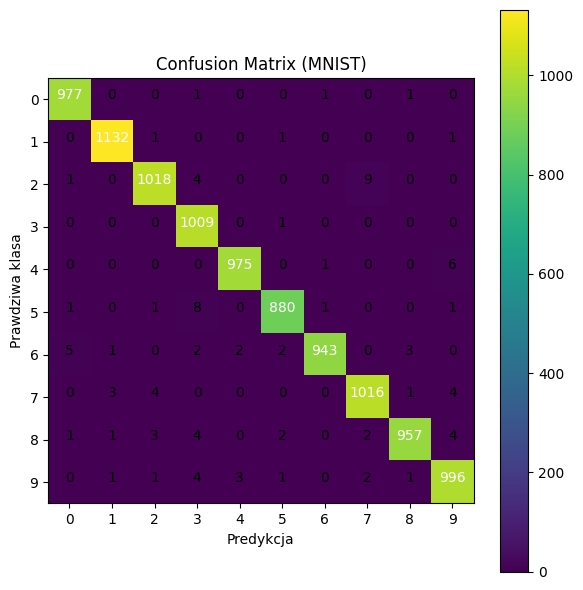

              precision    recall  f1-score   support

           0     0.9919    0.9969    0.9944       980
           1     0.9947    0.9974    0.9960      1135
           2     0.9903    0.9864    0.9883      1032
           3     0.9777    0.9990    0.9882      1010
           4     0.9949    0.9929    0.9939       982
           5     0.9921    0.9865    0.9893       892
           6     0.9968    0.9843    0.9905       958
           7     0.9874    0.9883    0.9878      1028
           8     0.9938    0.9825    0.9881       974
           9     0.9842    0.9871    0.9857      1009

    accuracy                         0.9903     10000
   macro avg     0.9904    0.9901    0.9902     10000
weighted avg     0.9903    0.9903    0.9903     10000



In [26]:
matrix()

Widzimy, że najczęściej mylonymi cyframi są cyfry do siebie podobne - 9 i 4, 7 i 2.

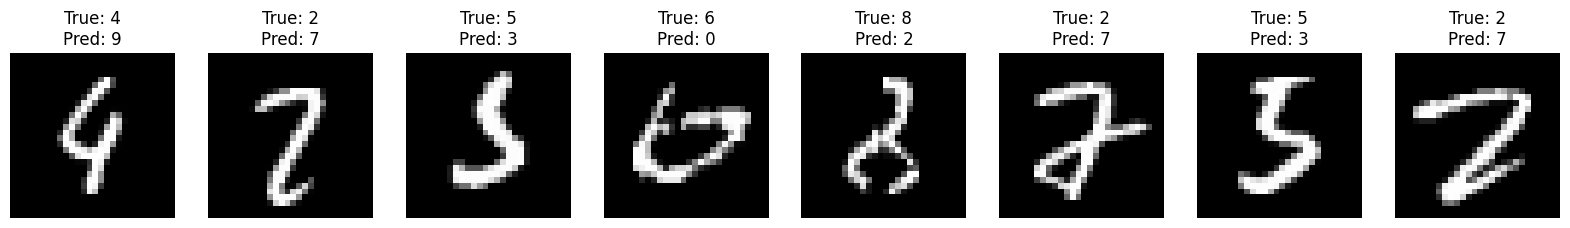

In [27]:
model.eval()
misclassified_images = []
misclassified_true = []
misclassified_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        outputs = model(xb)
        preds = outputs.argmax(dim=1)
        mask = preds != yb
        if mask.sum().item() > 0:
            # Zbieramy błędnie sklasyfikowane obrazy i etykiety
            misclassified_images.extend(xb[mask].cpu())
            misclassified_true.extend(yb[mask].cpu())
            misclassified_pred.extend(preds[mask].cpu())
        if len(misclassified_images) >= 8:
            break

# Wyświetlamy pierwsze 8 błędnych klasyfikacji
fig, axes = plt.subplots(1, 8, figsize=(20, 3))
for i in range(8):
    img = misclassified_images[i].squeeze()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'True: {misclassified_true[i].item()}\nPred: {misclassified_pred[i].item()}')
    axes[i].axis('off')
plt.show()

Większość cyfr to faktycznie cyfry napisane niedbale, więc nic dziwnego, że model ma z nimi trudności.

Podsumowując nasze eksperymenty, na początku spróbowaliśmy najprostszego rozwiązania, czyli zwykłej sieci MLP. Wyniki były raczej przeciętne, bo MLP traktuje obraz jak zwykły wektor liczb i nie bierze pod uwagę przestrzennej budowy obrazu. Potem przeszliśmy do sieci CNN, która dużo lepiej radzi sobie z obrazami. Okazało się, że już prosta sieć CNN z dwiema warstwami daje bardzo dobre wyniki. Testowaliśmy też różne wartości dropoutu i najlepsze wyniki dawała wartość 0.25. Dodanie Batch Normalization dodatkowo ustabilizowało uczenie, ale utrzymało podobne wyniki. Analiza macierzy pomyłek pokazała, że sieć najczęściej myli cyfry do siebie podobne, np. 4 z 9 albo 2 z 7. To naturalne, bo takie przypadki są trudne nawet dla ludzi. Ogólnie nasze sieci CNN osiągały ponad 99% skuteczności, co uważam za bardzo dobry wynik. W porównaniu do baseline różnica była ogromna.

# 8. Dodatek
Skoro mamy już wyćwiczony model to bardzo chciałam sprawdzić czy odgadnie moją cyfrę. Jako certyfikowana graficzka przygotowałam obrazek liczby 3. Model odgadł moją cyfrę.

(kod w tym dodatku to trochę vibe kodowanie, ale zrobiłam to z ciekawości)

Mounted at /content/drive


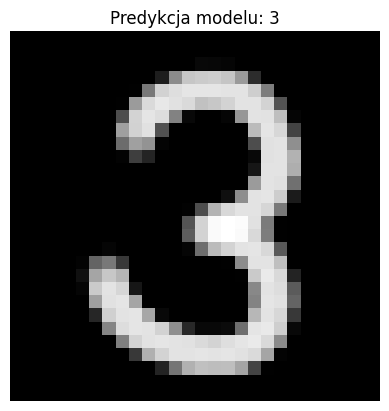

Model rozpoznał cyfrę jako: 3


In [32]:
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

img_path = "/content/drive/MyDrive/ML/NN_Titanic/digit.PNG"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

img = Image.open(img_path).convert("L")
tensor_img = transform(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(tensor_img)
    pred = output.argmax(1).item()

plt.imshow(img, cmap="gray")
plt.title(f"Predykcja modelu: {pred}")
plt.axis("off")
plt.show()

print(f"Model rozpoznał cyfrę jako: {pred}")


Sukces!